In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def set_fontsize(ax, fs):
    """
    Small function to set font sizes for figures
    """
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.tick_params(axis='both', which='minor', labelsize=fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

In [3]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 6      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ6 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 57.9 s


### Generating Trajectories

In [4]:
from scipy.interpolate import interp1d

x = np.linspace(-0.008, 0.008, int(np.sqrt(500)))
y = np.linspace(-0.013, 0.013, int(np.sqrt(500)))

def generateTrajectory(x,y):
    tmax = 0.9/200
    t = np.linspace(0,tmax,100)    
    intTrajX = interp1d(t, np.ones(len(t))*x, kind = 'linear')
    intTrajY = interp1d(t, np.ones(len(t))*y, kind = 'linear')
    intTrajZ = interp1d(t, -0.45+t*200, kind = 'linear')
    
    return intTrajX, intTrajY, intTrajZ, tmax

import itertools
interpolateTrajectories = []
for xi, yi in itertools.product(x,y):
    interpolateTrajectories.append((generateTrajectory(xi,yi)))

### Generating Fields from Trajectories

In [5]:
from fields import *
c, intfun = fit_potential_xyz("D:/Adiabatic Transfer/propagation/fields/"+'potentialQuadrupole.fld', 0.022, 0.019, 0, 0)
cP, intfunP = fit_potential_xyz('D:/Adiabatic Transfer/propagation/fields/'+'potentialElectrodes_offset_1kV.fld', 0.022, 0.019, .45, 0)
funEx,funEy,funEz,funEmag = combine_quadrupole_plate(c,intfun,cP,intfunP)

C:\Users\Olivier\Documents\CeNTREX Olivier\notebooks\non-adiabatic transitions\propagation\fields.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c = np.linalg.lstsq(vander, f)[0]


In [6]:
traj = interpolateTrajectories[10] 

Function to create the Hamiltonian matrix

In [7]:
def create_hamiltonian(Ex,Ey,Ez,Bx,By,Bz, Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m):
    HamE =  Hff_m + \
            Ex*HSx_m  + Ey*HSy_m + Ez*HSz_m + \
            Bx*HZx_m  + By*HZy_m + Bz*HZz_m
    return HamE

Function to generate the fields along a specified trajectory

In [8]:
def generate_fields(traj, t):
    x = traj[0](t)
    y = traj[1](t)
    z = traj[2](t)
    return [funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)]

### Testing a single evolution evaluation

In [9]:
t = np.arange(0, traj[3]/100, 1e-7)
B = [0,20,0]
E = generate_fields(traj, 0)
Hterms = (HamiltonianJ6.Hff_m, HamiltonianJ6.HSx_m, HamiltonianJ6.HSy_m, HamiltonianJ6.HSz_m, 
          HamiltonianJ6.HZx_m, HamiltonianJ6.HZy_m, HamiltonianJ6.HZz_m)

In [10]:
%%time
H = create_hamiltonian(*E, *B, *Hterms)

Wall time: 2 ms


In [11]:
from scipy.linalg import expm

In [12]:
%%time
expm(-1j*1e-7*H)

Wall time: 73 ms


array([[ 9.96422040e-01+8.43705925e-02j, -3.99298614e-03-3.37591058e-04j,
        -2.47208556e-03-2.09829606e-04j, ...,
         4.45237370e-22+4.53725276e-22j,  2.72678441e-22+2.84129314e-22j,
        -9.30863196e-24+2.16355374e-24j],
       [ 3.99298614e-03+3.37591056e-04j,  9.96477706e-01+8.37079365e-02j,
        -6.55740398e-05+6.61829990e-04j, ...,
        -1.10915685e-19-1.13347783e-19j,  8.81598345e-23-5.81801659e-23j,
         2.71619089e-22+2.85161700e-22j],
       [ 2.47208555e-03+2.09829603e-04j, -6.55740398e-05+6.61829990e-04j,
         9.96477706e-01+8.37079365e-02j, ...,
         8.81913431e-23-5.79862088e-23j, -1.08305220e-19-1.15849260e-19j,
         4.33055361e-22+4.65415428e-22j],
       ...,
       [ 8.99663301e-23-6.29288480e-22j,  2.26652412e-20-1.56959538e-19j,
         9.96313774e-23+3.48326257e-23j, ...,
         7.22465445e-01+6.91040647e-01j, -5.23818444e-04+5.17787226e-04j,
        -1.85456243e-03-1.64674274e-03j],
       [ 6.00604353e-23-3.89189771e-22j,  9.

### Evaluating Evolution over all Hamiltonians along a trajectory
Takes a lot of memory for small timesteps; actually not faster than simply running in a for loop

In [225]:
def create_hamiltonian_vector(Ex,Ey,Ez,Bx,By,Bz, Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m):
    HamE =  Hff_m[None,:,:]*np.ones(len(Ex))[:,None,None] + \
            Ex[:,None,None]*HSx_m[None,:,:] + Ey[:,None,None]*HSy_m[None,:,:] + \
            Ez[:,None,None]*HSz_m[None,:,:] + \
            Bx[:,None,None]*HZx_m[None,:,:] + By[:,None,None]*HZy_m[None,:,:] + \
            Bz[:,None,None]*HZz_m[None,:,:]
    return HamE

def create_evolution_vector(dt, H):
    evo = np.linalg.multi_dot([expm(-1j*dt*Hi) for Hi in H])
    return evo

def calculate_evolution(dt, Ex,Ey,Ez,Bx,By,Bz, Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m):
    H = create_hamiltonian_vector(Ex,Ey,Ez,Bx,By,Bz, Hff_m, HSx_m, HSy_m, HSz_m, HZx_m, HZy_m, HZz_m)
    phiInit = np.linalg.eigh(H[0])[1][:,35]
    evo = create_evolution_vector(dt, H)
    phiFinal = evo@phiInit
    return phiInit, phiFinal

In [15]:
dt = 1e-5
t = np.arange(0, traj[3], dt)
B = [np.ones(len(t))*0, np.ones(len(t))*20, np.ones(len(t))*0]
E = generate_fields(traj, t)
Hterms = (HamiltonianJ6.Hff_m, HamiltonianJ6.HSx_m, HamiltonianJ6.HSy_m, HamiltonianJ6.HSz_m, 
          HamiltonianJ6.HZx_m, HamiltonianJ6.HZy_m, HamiltonianJ6.HZz_m)

In [208]:
%%time
H = create_hamiltonian_vector(*E, *B, *Hterms)

Wall time: 4.01 s


In [209]:
%%time
evo = create_evolution_vector(dt, H)

Wall time: 31.5 s


In [227]:
%%time
state = calculate_evolution(dt, *E, *B, *Hterms)
np.abs(state[1].conj()@state[0])**2

Wall time: 34.5 s


0.9150341671239618

### Propagation in a for loop
faster than evolution over all hamiltonians, probably because of memory usage

In [13]:
def Evec(x,y,z):
    return funEx(x,y,z), funEy(x,y,z), funEz(x,y,z)

def get_coordinates(traj, t):
    return traj[0](t), traj[1](t), traj[2](t)

def hamiltonian(E,B):
    return create_hamiltonian(*E, *B, *Hterms)

def propagate(traj, dt, E, B):
    B = [0,20,0]
    x,y,z = get_coordinates(traj, 0)
    
    H0 = create_hamiltonian(*Evec(x,y,z),*B,*Hterms)
    phi0 = np.linalg.eigh(H0)[1][:,35]
    
    ti = 0
    phi = phi0.copy()
    while ti <= traj[-1]:
        x,y,z = get_coordinates(traj, ti)
        H = create_hamiltonian(*Evec(x,y,z), *B, *Hterms)
        phi = expm(-1j*dt*H)@phi
        ti += dt
    return phi0, phi

In [16]:
%%time
state_propagate = propagate(traj, dt, Evec, [0,20,0])
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 17.3 s


0.9158569667593981

### Manual Adaptive Propagation
Divide trajectory into regions with large and small change in field and vary the timestep accordingly

In [17]:
def propagate_exp_adaptive(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham(E(*get_coordinates(traj, 0)), B))[1][:,35]
    
    phi = phi0.copy()
    ti = 0
    while ti <= traj[-1]:
        xi = traj[0](ti)
        yi = traj[1](ti)
        zi = traj[2](ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi = expm(-1j*ham(E(xi,yi,zi), B)*dt)@phi
        ti += dt

    return phi0, phi

Investigating several different timesteps

In [18]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0])
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 24.6 s


0.9158569667593981

In [254]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (1e-6, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 33.1 s


0.9934793817121238

In [255]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 57.2 s


0.9975214714198636

In [256]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (5e-7, 5e-6))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 1min 4s


0.9978466974680991

In [257]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (1e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 3min 51s


0.9967498292521272

### Choosing the worst trajectory to see influence of dt
Worst trajectory identified from full simulation in `State Propagation Parallel Homogeneous Offset`

### FOUND PROBLEM
Was using the old lens potentials because the propagation scheme was loading the old potential file

In [26]:
traj = interpolateTrajectories[275]

In [27]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0])
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 14.6 s


0.6304061712651611

In [263]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (1e-6, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 33 s


0.7613768579568236

In [264]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 58.6 s


0.7711677036394219

In [265]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (5e-7, 1e-6))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 2min 14s


0.7746535808802856

In [270]:
get_coordinates(traj,0)

(array(0.00114286), array(0.00061905), array(-0.45))

### Does not correspond to parallel simulation; do a coarse scan single core
Low precision in dT too, only 1e-5 instead of 1e-7 like in the full scan, just to get a sense of where the low probabilities are compared to the parallel simulation

### FOUND PROBLEM
Was using the old lens potentials because the propagation scheme was loading the old potential file

In [280]:
from tqdm import tqdm_notebook as tqdm

probs = []
trajs = []
idlist = []
idT = 0
for traj in tqdm(interpolateTrajectories[::4]):
    idT += 4
    state = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0])
    probs.append(np.abs(state[1].conj()@state[0])**2)
    trajs.append(traj)
    idlist.append(idT)

In [281]:
from scipy.interpolate import griddata
from matplotlib import colors

def create_grid_trajectories(interpolateTrajectories, probabilities):
    x0 = []
    y0 = []
    for idL in range(len(interpolateTrajectories)):
        traj = interpolateTrajectories[idL]
        x0.append(traj[0](0.000))
        y0.append(traj[1](0.000))
    x0 = np.array(x0)
    y0 = np.array(y0)
    
    dx = np.min(np.abs(np.diff(x0)[np.diff(x0) != 0]))
    dy = np.min(np.abs(np.diff(y0)[np.diff(y0) != 0]))
    
    xi = np.linspace(x0.min(), x0.max(), int(np.sqrt(500))*2)
    yi = np.linspace(y0.min(), y0.max(), int(np.sqrt(500))*2)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x0,y0), probabilities, (X,Y), method = 'linear')
    return x0,y0,xi,yi,X,Y,Z
    
def plot_grid_trajectories(interpolateTrajectories, probabilities):
    x0,y0,xi,yi,X,Y,Z = create_grid_trajectories(interpolateTrajectories, probabilities)
    fig, ax = plt.subplots(figsize = (14,11))
    cax = ax.pcolormesh(X,Y,Z)
    vmin, vmax = cax.get_clim()
    ax.scatter(x0, y0, c = probabilities, edgecolors = 'k', s = 50, vmin = vmin, vmax = vmax, lw = 2)
    cbar = fig.colorbar(cax)
    cbar.set_label('probability', fontsize = 15)
    cs = ax.contour(xi, yi, Z, colors = ['C3', 'k'], levels = [0.95, 0.99], linewidths = 3)
    cbar.add_lines(cs)
    ax.set_xlabel("x [m]", fontsize = 15)
    ax.set_ylabel("y [m]", fontsize = 15)
    ax.set_title('Probability to stay in state', fontsize = 15);
    ax.set_xticks([-0.008, -0.004, 0, 0.004, 0.008])
    set_fontsize(ax, 15)
    set_fontsize(cbar.ax, 15)
    ax.set_aspect(1/1.35)

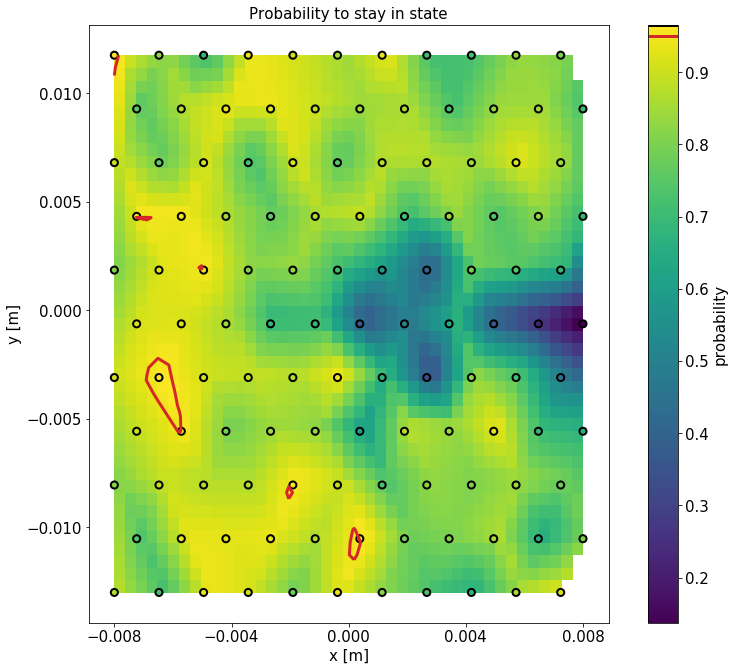

In [282]:
plot_grid_trajectories(trajs, probs)

Minimum moved when compared to the parallel scan; now at the far right, which is also more what I expected to start with

### Magnus Equation

In [114]:
def propagate_magnus_adaptive(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    
    phi0 = np.linalg.eigh(ham(E(*get_coordinates(traj, 0)), B))[1][:,35]
    
    c = np.sqrt(3)/6
    d = np.sqrt(3)/12
    
    ti = 0
    phi = phi0.copy()
    while ti <= traj[-1]:
        xi,yi,zi = get_coordinates(traj, ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        
        try:
            coords = get_coordinates(traj, ti+(0.5+c)*dt)
            a1 = -1j*ham(E(*coords), B)
            coords = get_coordinates(traj, ti+(0.5-c)*dt)
            a2 = -1j*ham(E(*coords), B)
            sigma = 0.5*dt*(a1+a2)+d*(dt**2)*(a2@a1-a1@a2)
            phi = expm(sigma)@phi
        except ValueError:
            break        
        ti += dt
        
    return phi0, phi

In [115]:
traj = interpolateTrajectories[1]

In [116]:
%%time
state = propagate_magnus_adaptive(hamiltonian, traj, Evec, [0,20,0], (1e-5,1e-5))
np.abs(state[1].conj()@state[0])**2

Wall time: 14.7 s


0.007921493821045124

In [113]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (1e-5,1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 13.2 s


0.9098119397342436

In [126]:
def Ef(x,y,z):
    return 0, 400*z**2+40, 0

In [127]:
%%time
state = propagate_magnus_adaptive(hamiltonian, traj, Ef, [0,20,0], (1e-5,1e-5))
np.abs(state[1].conj()@state[0])**2

Wall time: 15.6 s


0.029138029621165632

In [130]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Ef, [0,20,0], (1e-5,1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 14.3 s


0.9999854166159062

In [321]:
def propagate_magnus(ham, traj, E, B, dt = 5e-7):
    
    phi0 = np.linalg.eigh(ham(E(*get_coordinates(traj, 0)), B))[1][:,35]
    
    t = np.arange(0, traj[-1], dt)
    phi = np.zeros([len(t), len(phi0)], dtype = complex)
    
    c = np.sqrt(3)/6
    d = np.sqrt(3)/12
    
    ti = 0
    phi[0] = phi0
    for idx, ti in enumerate(t[:-1]):
        coords = get_coordinates(traj, ti+(0.5+c)*dt)
        a1 = -1j*ham(E(*coords), B)
        coords = get_coordinates(traj, ti+(0.5-c)*dt)
        a2 = -1j*ham(E(*coords), B)
        sigma = 0.5*dt*(a1+a2)+d*(dt**2)*(a2@a1-a1@a2)
        phi[idx+1] = expm(sigma)@phi[idx]
        
    return phi

In [322]:
%%time
phi = propagate_magnus(hamiltonian, traj, Ef, [0,20,0])

Wall time: 4min 23s


In [323]:
from order_eigenstates import *

In [324]:
%%time
t = np.arange(0, traj[-1], dt)
B = [0,20,0]
H = [hamiltonian(Evec(*get_coordinates(traj, ti)), B) for ti in t]
energies, eigenvectors = np.linalg.eigh(H)

Wall time: 7.49 s


In [325]:
%%time
energies, eigenvectors = eigenshuffle(H, return_reorder = False)

Wall time: 3min 45s


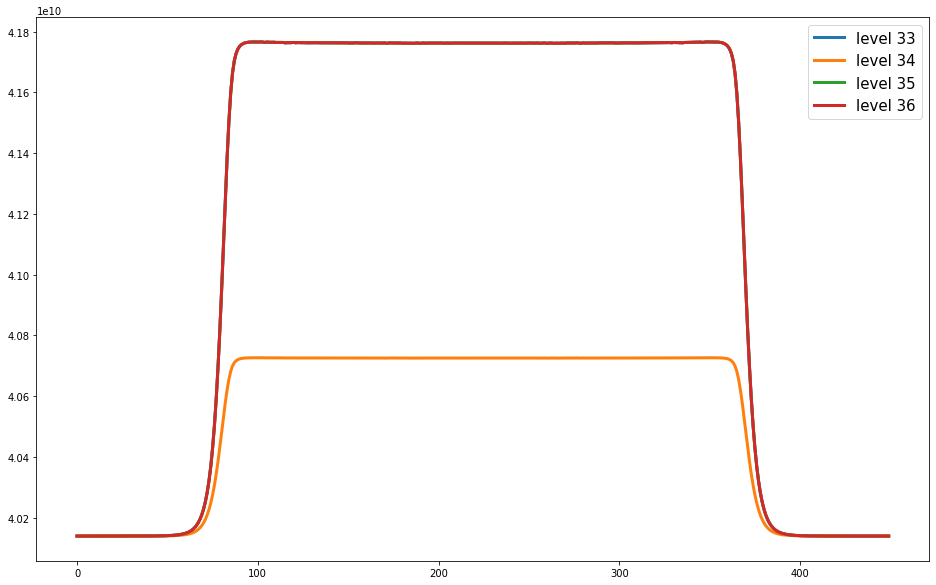

In [326]:
fig, ax = plt.subplots(figsize = (16,10))
nstart, nstop = 0, energies.shape[0]
for l in [32,33,34,35]:
    ax.plot(energies[nstart:nstop,l], label = 'level {0}'.format(l+1), lw = 3);
ax.legend(fontsize = 15)

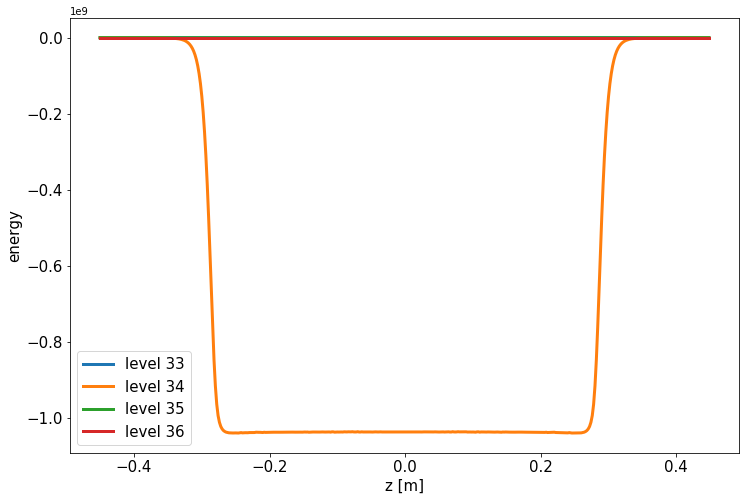

In [327]:
fig, ax = plt.subplots(figsize = (12,8))
nstart, nstop = 0, energies.shape[0]
for l in [32,33,34,35]:
    ax.plot(traj[2](np.array(t)), energies[nstart:nstop,l]-energies[nstart:nstop,35], label = 'level {0}'.format(l+1), lw = 3);
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('energy')
set_fontsize(ax, 15)

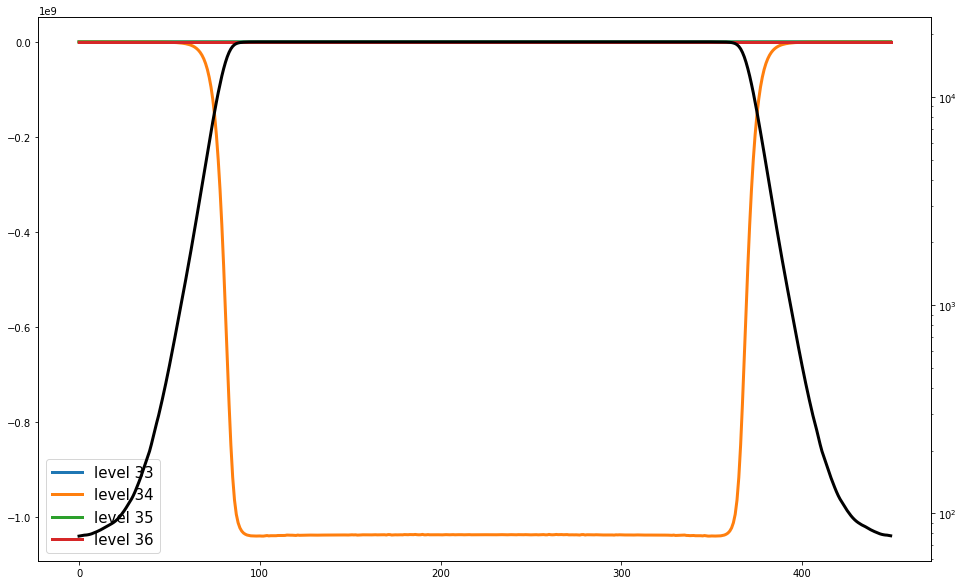

In [328]:
fig, ax = plt.subplots(figsize = (16,10))
nstart, nstop = 0, energies.shape[0]
for l in [32,33,34,35]:
    ax.plot(energies[nstart:nstop,l]-energies[nstart:nstop,35], label = 'level {0}'.format(l+1), lw = 3);
ax1 = ax.twinx()
xi = interpolateTrajectories[0][0](t)
yi = interpolateTrajectories[0][1](t)
zi = interpolateTrajectories[0][2](t)
Exi = funEx(xi, yi,zi)
Eyi = funEy(xi, yi,zi)
Ezi = funEz(xi, yi,zi)
E = np.sqrt(Exi**2+Eyi**2+Ezi**2)
ax1.plot(E, 'k', lw = 3)
ax1.set_yscale('log')
ax.legend(fontsize = 15)

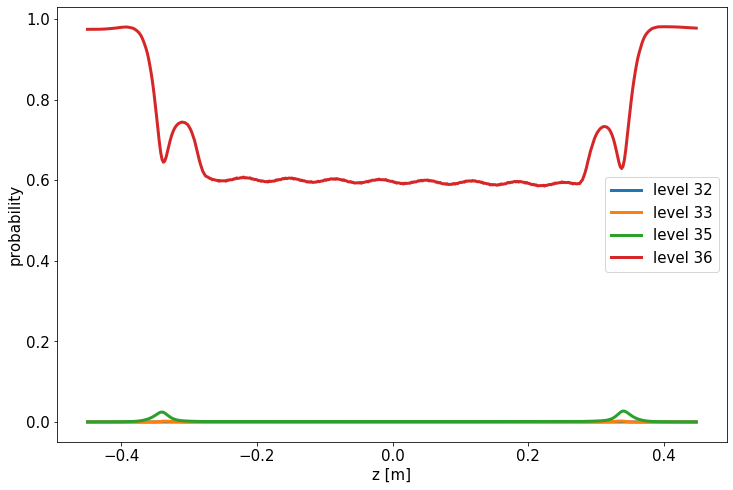

In [329]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phi, eigenvectors)

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL

## Putting Major Fields along z (more diagonal matrix)

Checking to see if that speeds up the propagation calculation  

In [264]:
def propagate_exp_adaptive_z(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham(E(*get_coordinates_z(traj, 0)), B))[1][:,35]
    
    phi = phi0.copy()
    ti = 0
    while ti <= traj[-1]:
        xi,yi,zi = get_coordinates_z(traj, ti)
        if (xi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (xi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi = expm(-1j*ham(E(xi,yi,zi), B)*dt)@phi
        ti += dt

    return phi0, phi

In [186]:
traj = interpolateTrajectories[10] 

In [187]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 58.7 s


0.9975214714198636

In [188]:
def EvecZ(x,y,z):
    return funEz(x,y,z), funEx(x,y,z), funEy(x,y,z)

def get_coordinates_z(traj, t):
    return traj[2](t), traj[0](t), traj[1](t)

In [189]:
%%time
state_propagate = propagate_exp_adaptive(hamiltonian, traj, EvecZ, [0,0,20], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 58.4 s


0.9975214392687604

Not any faster unfortunately, probably because expm doesn't care about the matrix being diagonal

### Reducing Hamiltonian Magnitude

In [190]:
def propagate_exp_adaptive_magnitude(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham(E(*get_coordinates(traj, 0)), B)/1e6)[1][:,35]
    
    phi = phi0.copy()
    ti = 0
    while ti <= traj[-1]:
        xi, yi, zi = get_coordinates(traj, 0)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi = expm(-1j*ham(E(xi,yi,zi), B)/1e6*dt)@phi
        ti += dt

    return phi0, phi

In [191]:
%%time
state_propagate = propagate_exp_adaptive_magnitude(hamiltonian, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 8.12 s


1.0000000000000777

### Using a algorithm I found from matlab
$expm(X) = V*diag(exp(diag(D)))/V$ where V,D = eigenvectors, eigenvalues

Don't have this working yet, result for even one timestep is different

In [308]:
def propagate_exp_adaptive_matlabmethod(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    eigenvalues, eigenvectors = np.linalg.eigh(ham(E(*get_coordinates(traj, 0)), B))
    phi0 = eigenvectors[:,35]
    
    phi = phi0.copy()
    ti = 0
    while ti <= traj[-1]:
        xi, yi, zi = get_coordinates(traj, ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        D, V = np.linalg.eigh(-1j*dt*ham(E(xi,yi,zi), B))
        phi = V*np.diag(np.exp(np.diag(D)))/V@phi
        ti += dt

    return phi0, phi

In [309]:
%%time
state_propagate = propagate_exp_adaptive_matlabmethod(hamiltonian, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


Wall time: 23.1 s


nan

In [310]:
h = hamiltonian(Evec(*get_coordinates(traj, 0)), [0,20,0])

In [319]:
%%time
eigenvalues, eigenvectors = np.linalg.eigh(-1j*1e-7*h)
result_matlab = eigenvectors@np.diag(np.exp(np.diag(eigenvalues)))/eigenvectors

Wall time: 8.97 ms


In [320]:
%%time
result_expm = expm(-1j*1e-7*h)

Wall time: 32 ms


Method is about 4 times faster than expm, but sometimes encounters invalid values. More importantly it doesn't actually return the same result even for one timestep

## Checking Trajectory with Normal Propagation Code

In [423]:
def propagate_exp_adaptive_return(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham(E(*get_coordinates(traj, 0)), B))[1][:,35]
    
    phi = [phi0.copy()]
    t = [0]
    ti = 0
    while ti <= traj[-1]:
        xi = traj[0](ti)
        yi = traj[1](ti)
        zi = traj[2](ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi.append(expm(-1j*ham(E(xi,yi,zi), B)*dt)@phi[-1])
        ti += dt
        t.append(ti)
    t[-1] = t[-2]
    return t, phi

In [424]:
traj = interpolateTrajectories[10]

In [425]:
%%time
t, phi = propagate_exp_adaptive_return(hamiltonian, traj, Evec, [0,20,0], (1e-7, 1e-5))
np.abs(phi[-1].conj()@phi[0])**2

Wall time: 4min 47s


0.9967498292521272

In [426]:
%%time
B = [0,20,0]
H = [hamiltonian(Evec(*get_coordinates(traj, ti)), B) for ti in t]
energies, eigenvectors = np.linalg.eigh(H)

Wall time: 1min 30s


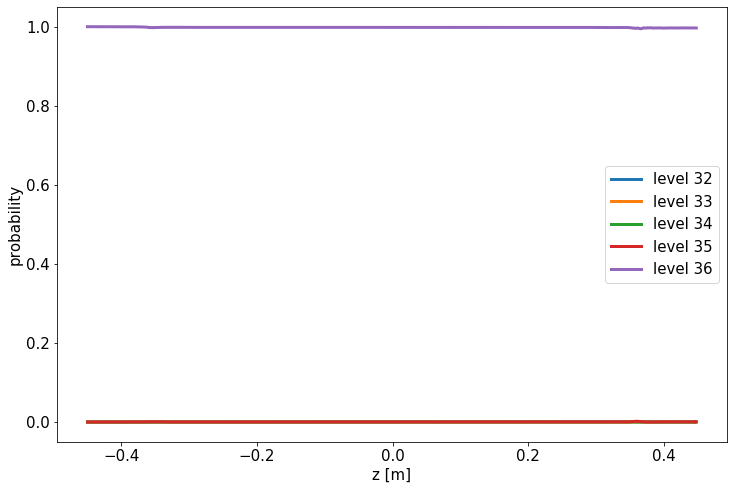

In [427]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phi, eigenvectors)

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,33,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL

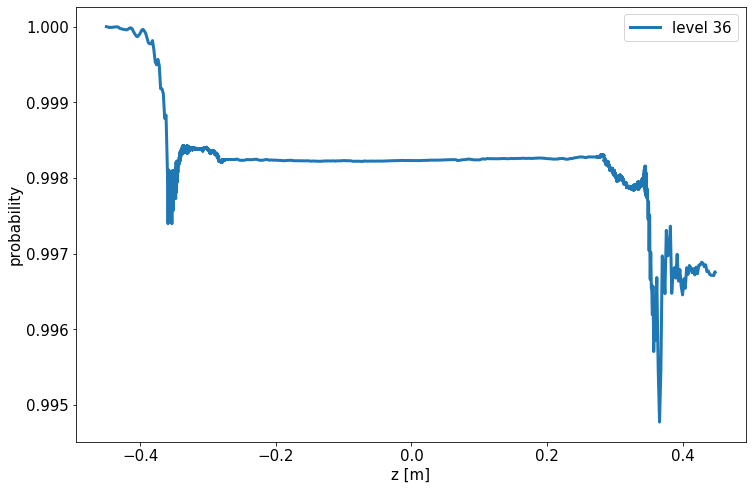

In [428]:
fig, ax = plt.subplots(figsize = (12,8))
for idL in [35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL

## Start excluding J levels to see if the calculation changes

In [429]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 5      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ5 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 28.9 s


In [430]:
def propagate_exp_adaptive(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham.create_hamiltonian(*E(*get_coordinates(traj,0)), *B))[1][:,35]
    
    phi = phi0.copy()
    ti = 0
    while ti <= traj[-1]:
        xi, yi, zi = get_coordinates(traj, ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi = expm(-1j*ham.create_hamiltonian(*E(xi,yi,zi), *B)*dt)@phi
        ti += dt

    return phi0, phi

In [431]:
%%time
state_propagate = propagate_exp_adaptive(HamiltonianJ6, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 1min 24s


0.9975214714198636

### Excluding the J=6 Level

In [432]:
%%time
state_propagate = propagate_exp_adaptive(HamiltonianJ5, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 42.5 s


0.9972287811725351

### Excluding the J=5 Level

In [433]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 4      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ4 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 14 s


In [434]:
%%time
state_propagate = propagate_exp_adaptive(HamiltonianJ4, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 20.4 s


0.9982508386148782

### Excluding the J=4 Level

In [435]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 3      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ3 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 5.35 s


In [436]:
%%time
state_propagate = propagate_exp_adaptive(HamiltonianJ3, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 9.23 s


0.9981093355619753

#### Including the J=7 Level

In [437]:
%%time
from quantumoperators import *
from hamiltonianoperators import *

Jmax = 7      # max J value in Hamiltonian
I_Tl = 1/2    # I1 in Ramsey's notation
I_F = 1/2     # I2 in Ramsey's notation

HamiltonianJ7 = Hamiltonian(Jmax, I_Tl, I_F)

Wall time: 1min 35s


In [438]:
%%time
state_propagate = propagate_exp_adaptive(HamiltonianJ7, traj, Evec, [0,20,0], (5e-7, 1e-5))
np.abs(state_propagate[1].conj()@state_propagate[0])**2

Wall time: 5min 9s


0.9975760036453271

## Looking at the probabilities to see effect of excluding states

In [439]:
def propagate_exp_adaptive_save(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham.create_hamiltonian(*E(*get_coordinates(traj,0)), *B))[1][:,35]
    
    phi = [phi0.copy()]
    ti = 0
    t = [0]
    while ti <= traj[-1]:
        xi, yi, zi = get_coordinates(traj, ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi.append(expm(-1j*ham.create_hamiltonian(*E(xi,yi,zi), *B)*dt)@phi[-1])
        ti += dt
        t.append(ti)
    t[-1] = t[-2]
    return t, phi

In [440]:
%%time
t, phiJ7 = propagate_exp_adaptive_save(HamiltonianJ7, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 5min 5s


In [441]:
%%time
t, phiJ6 = propagate_exp_adaptive_save(HamiltonianJ6, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 1min 21s


In [442]:
%%time
t, phiJ5 = propagate_exp_adaptive_save(HamiltonianJ5, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 46 s


In [443]:
%%time
t, phiJ4 = propagate_exp_adaptive_save(HamiltonianJ4, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 21.9 s


In [444]:
%%time
B = [0,20,0]
H = [HamiltonianJ7.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ7 = eigenvectors

Wall time: 1min


In [445]:
%%time
B = [0,20,0]
H = [HamiltonianJ6.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ6 = eigenvectors

Wall time: 20.1 s


In [446]:
%%time
B = [0,20,0]
H = [HamiltonianJ5.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ5 = eigenvectors

Wall time: 12.3 s


In [447]:
%%time
B = [0,20,0]
H = [HamiltonianJ4.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ4 = eigenvectors

Wall time: 7.87 s


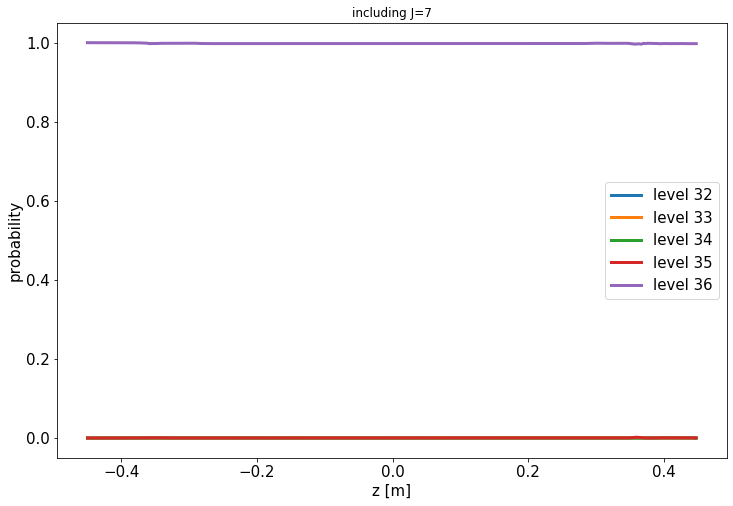

In [448]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phiJ7, eigvecsJ7)

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,33,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)
ax.set_title('including J=7')

del idL

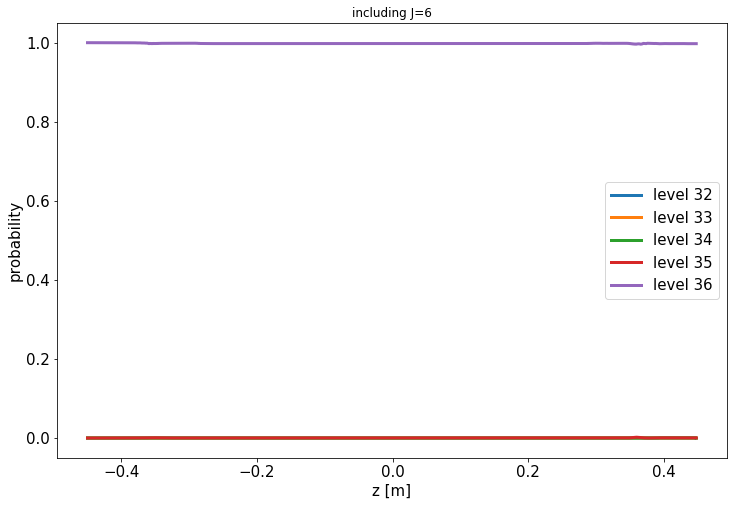

In [449]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phiJ6, eigvecsJ6)

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,33,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)
ax.set_title('including J=6')

del idL

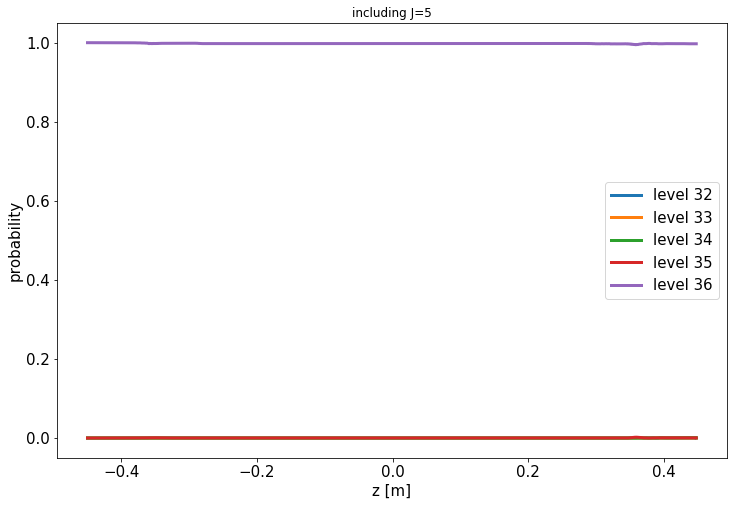

In [450]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phiJ5, eigvecsJ5)

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,33,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)
ax.set_title('including J=5')

del idL

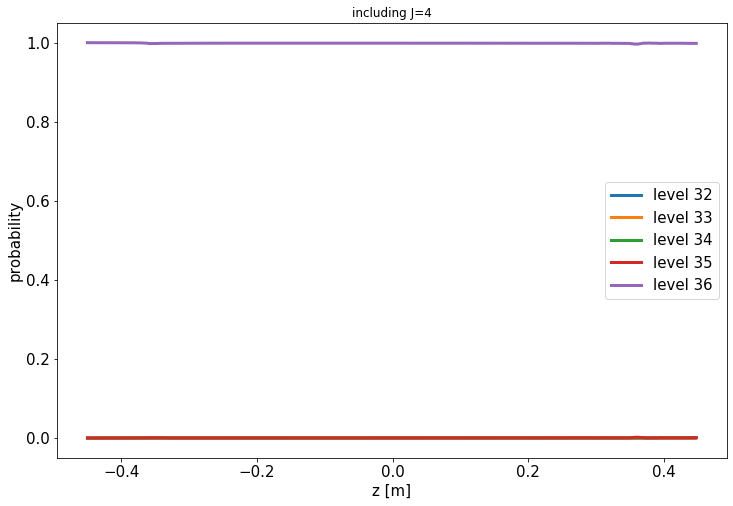

In [451]:
from propagation import *
probabilities = calculate_state_probabilities_eigvecs(phiJ4, eigvecsJ4)

fig, ax = plt.subplots(figsize = (12,8))
for idL in [31,32,33,34,35]:
    ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(idL+1));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)
ax.set_title('including J=4')

del idL

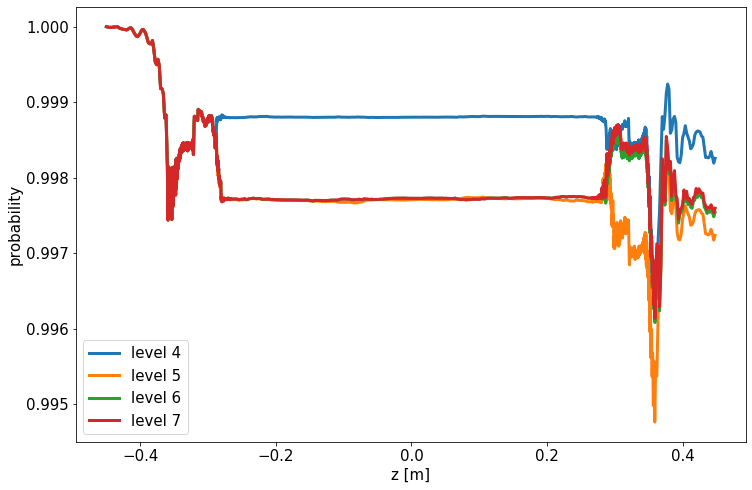

In [452]:
fig, ax = plt.subplots(figsize = (12,8))
for J, eigvecs, phiJ in zip([4,5,6,7],[eigvecsJ4, eigvecsJ5, eigvecsJ6, eigvecsJ7],[phiJ4, phiJ5, phiJ6, phiJ7]):
    probabilities = calculate_state_probabilities_eigvecs(phiJ, eigvecs)
    for idL in [35]:
        ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(J));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL

So not a lot of difference between the levels

### Now check the same for a bad trajectory (avoided crossing)

In [464]:
def propagate_exp_adaptive_save(ham, traj, E, B, dtAdaptive = (1e-5, 1e-5)):
    phi0 = np.linalg.eigh(ham.create_hamiltonian(*E(*get_coordinates(traj,0)), *B))[1][:,35]
    
    phi = [phi0.copy()]
    ti = 0
    t = [0]
    while ti <= traj[-1]:
        xi, yi, zi = get_coordinates(traj, ti)
        if (zi > -0.36) & (zi < -0.260):
            dt = dtAdaptive[0]
        elif (zi < 0.36) & (zi > 0.260):
            dt = dtAdaptive[0]
        else:
            dt = dtAdaptive[1]
        phi.append(expm(-1j*ham.create_hamiltonian(*E(xi,yi,zi), *B)*dt)@phi[-1])
        ti += dt
        t.append(ti)
    t[-1] = t[-2]
    return t, phi

In [465]:
for idx, traj in enumerate(interpolateTrajectories):
    if np.abs(traj[1](0)) < 0.001:
        if traj[0](0) > 0.006:
            print(f'trajectory {idx}: (x,y) = ({traj[0](0):.1e}, {traj[1](0):.1e})')

trajectory 428: (x,y) = (6.5e-03, -6.2e-04)
trajectory 429: (x,y) = (6.5e-03, 6.2e-04)
trajectory 450: (x,y) = (7.2e-03, -6.2e-04)
trajectory 451: (x,y) = (7.2e-03, 6.2e-04)
trajectory 472: (x,y) = (8.0e-03, -6.2e-04)
trajectory 473: (x,y) = (8.0e-03, 6.2e-04)


trajectory 472 or 473 are closest to a zero crossing

In [466]:
traj = interpolateTrajectories[472]

In [467]:
%%time
t, phiJ7 = propagate_exp_adaptive_save(HamiltonianJ7, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 5min 9s


In [468]:
%%time
t, phiJ6 = propagate_exp_adaptive_save(HamiltonianJ6, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 1min 31s


In [469]:
%%time
t, phiJ5 = propagate_exp_adaptive_save(HamiltonianJ5, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 42.5 s


In [470]:
%%time
t, phiJ4 = propagate_exp_adaptive_save(HamiltonianJ4, traj, Evec, [0,20,0], (5e-7, 1e-5))

Wall time: 25.8 s


In [471]:
%%time
B = [0,20,0]
H = [HamiltonianJ7.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ7 = eigenvectors

Wall time: 58 s


In [472]:
%%time
B = [0,20,0]
H = [HamiltonianJ6.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ6 = eigenvectors

Wall time: 21.9 s


In [473]:
%%time
B = [0,20,0]
H = [HamiltonianJ5.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ5 = eigenvectors

Wall time: 13.7 s


In [474]:
%%time
B = [0,20,0]
H = [HamiltonianJ4.create_hamiltonian(*Evec(*get_coordinates(traj, ti)), *B) for ti in t]
_, eigenvectors = np.linalg.eigh(H)
eigvecsJ4 = eigenvectors

Wall time: 8.68 s


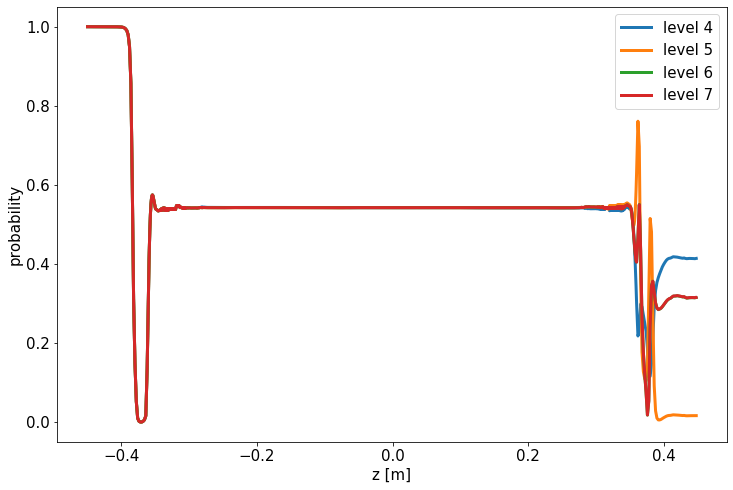

In [477]:
fig, ax = plt.subplots(figsize = (12,8))
for J, eigvecs, phiJ in zip([4,5,6,7],[eigvecsJ4, eigvecsJ5, eigvecsJ6, eigvecsJ7],[phiJ4, phiJ5, phiJ6, phiJ7]):
    probabilities = calculate_state_probabilities_eigvecs(phiJ, eigvecs)
    for idL in [35]:
        ax.plot(traj[2](t), probabilities[:,idL], lw = 3, label = 'level {0}'.format(J));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL

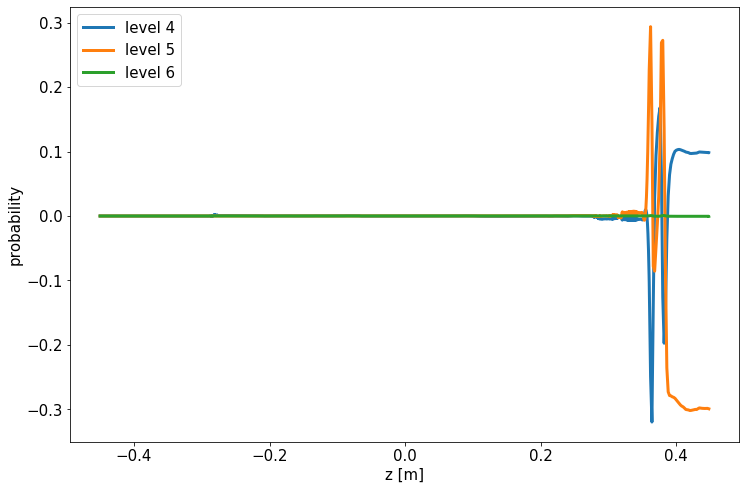

In [478]:
fig, ax = plt.subplots(figsize = (12,8))
p7 = calculate_state_probabilities_eigvecs(phiJ7, eigvecsJ7)
for J, eigvecs, phiJ in zip([4,5,6],[eigvecsJ4, eigvecsJ5, eigvecsJ6],[phiJ4, phiJ5, phiJ6]):
    probabilities = calculate_state_probabilities_eigvecs(phiJ, eigvecs)
    for idL in [35]:
        ax.plot(traj[2](t), probabilities[:,idL]-p7[:,idL], lw = 3, label = 'level {0}'.format(J));
ax.legend(fontsize = 15)
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL

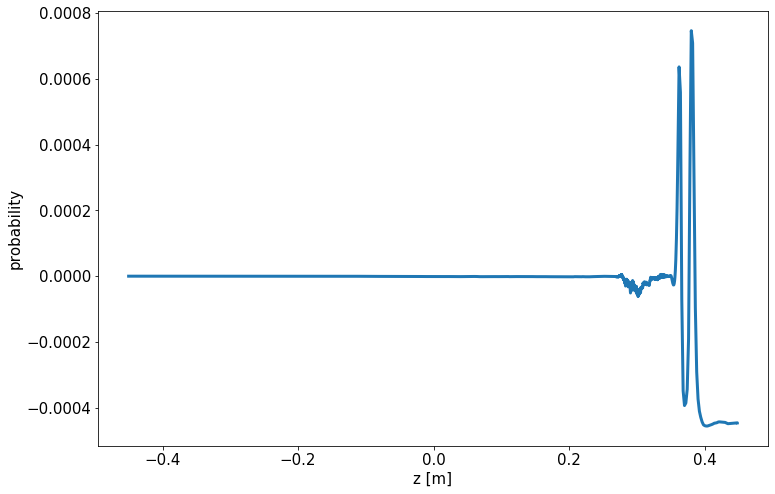

In [481]:
fig, ax = plt.subplots(figsize = (12,8))
p6 = calculate_state_probabilities_eigvecs(phiJ6, eigvecsJ6)
p7 = calculate_state_probabilities_eigvecs(phiJ7, eigvecsJ7)

idL = 35

ax.plot(traj[2](t), p6[:,idL]-p7[:,idL], lw = 3);
ax.set_xlabel('z [m]')
ax.set_ylabel('probability')
set_fontsize(ax, 15)

del idL